In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from easydict import EasyDict
from tqdm.notebook import tqdm,trange
from sklearn.metrics import roc_auc_score

In [2]:
def LossFn(alpha):
    epsilon = 10e-10
    
    def loss_function(pos_out, unlabeled_out):
        loss_neg = -tf.reduce_mean(tf.math.log(1 - unlabeled_out + epsilon))
        loss_neg = tf.maximum(0.0, loss_neg + alpha * tf.reduce_mean(tf.math.log(1 - pos_out + epsilon)))
        loss_pos = -alpha * tf.reduce_mean(tf.math.log(pos_out + epsilon))
        return loss_neg + loss_pos
    return loss_function

In [31]:
# export
def batch(x, y, n_p, n_u):
    x_p, ix_p = batchPos(x, y, n_p)
    x_u, ix_u = batchUL(x, y, n_u)
    xx = np.concatenate((x_p, x_u), axis=0)
    ix = np.concatenate((ix_p, ix_u), axis=0)
    return xx, y[ix, :], x_p, x_u, ix


def batchPos(x, y, n_p):
    return batchY(x, y, 1, n_p)


def batchUL(x, y, n_u):
    return batchY(x, y, 0, n_u)

def batchY(x, y, value, n, *args):
    ix = (y == value).flatten( )
    ix_all = np.arange(np.size(y))
    ix = ix_all[ix]
    if args:
        p = args[0].flatten()
        p = p[ix]
        ix_p = bernoulli.rvs(p)
        ix_p = np.cast['bool'](ix_p)
        ix = ix[ix_p]
    ix = np.random.choice(ix, n, replace=True)
    xx = x[ix, :]
    return xx, ix

In [451]:
class Mixture:

    def __init__(self, components, mixing_proportion):
        self.comps = components
        self.mixProp = mixing_proportion

    def pdf(self, x):
        return np.add(*[pi * comp.pdf(x) for (comp,pi) in zip(self.comps, self.mixProp)])

    def cdf(self, x):
        return np.add((p * comp.cdf(x) for (comp, p) in zip(self.comps, self.mixProp)), axis=-1)

    def rvs(self, size):
        sizes = np.cast['int32'](np.floor(size * self.mixProp))
        #pdb.set_trace()
        delta = np.cast['int32'](size - np.sum(sizes))
        ix = np.random.choice(np.size(self.mixProp), size=delta, p=self.mixProp)
        for ii in ix:
            sizes[ii] = sizes[ii] + 1
        dim = np.size(self.comps[0].rvs(size=1))
        x = np.empty([0, dim])
        for (s, comp) in zip(sizes, self.comps):
            new = comp.rvs(size=[s, 1])
            if len(new.shape) == 1:
                new = np.expand_dims(new,1)
            x = np.concatenate((x,new), axis=0)
        #pdb.set_trace()
        return x

    def rvsCompInfo(self, size):
        sizes = np.cast['int32'](np.floor(size * self.mixProp))
        #pdb.set_trace()
        delta = np.cast['int32'](size - np.sum(sizes))
        ix = np.random.choice(np.size(self.mixProp), size=delta, p=self.mixProp)
        for ii in ix:
            sizes[ii] = sizes[ii] + 1
        dim = np.size(self.comps[0].rvs(size=1))
        x = np.empty([0, dim])
        y = np.empty([0, 1])
        k = 0
        for (s, comp) in zip(sizes, self.comps):
            new = comp.rvs(size=[s, 1])
            print(x.shape, new.shape)
            x = np.concatenate((x, new), axis=0)
            y = np.concatenate((y, np.zeros([s, 1]) + k), axis=0)
            k = k + 1
        #pdb.set_trace()
        return x, y

    def component_pdfs(self, x):
        return (comp.pdf(x) for comp in self.comps)


In [607]:
NLP=100
NUP = 5000
NN = 5000
DIM = 32
ZDIM = max(1,int(DIM/2))
OFFSET = .09

classPrior = NUP / (NUP + NN)

f0 = Mixture([
    ss.multivariate_normal(np.zeros(DIM) + OFFSET,np.eye(DIM)),
    ss.multivariate_normal(np.zeros(DIM) + 2 * OFFSET, np.eye(DIM))
],[.5,.5])
f1 = Mixture([
    ss.multivariate_normal(np.zeros(DIM) - OFFSET,np.eye(DIM)),
    ss.multivariate_normal(np.zeros(DIM) - 2 * OFFSET, np.eye(DIM))
],[.5,.5])
posterior = lambda x: classPrior * f1.pdf(x).ravel() / (classPrior * f1.pdf(x).ravel() + (1 - classPrior) * f0.pdf(x).ravel())

xUnlabeled = np.concatenate((f0.rvs(NN),f1.rvs(NUP)))
yPN = np.concatenate((np.zeros(NN),
                    np.ones(NUP))).astype(bool)
xPos = f1.rvs(NLP)


xPosTrain, xPosVal = train_test_split(xPos,test_size=.1)
xUnlabeledTrain,xUnlabeledVal,yPNTrain,yPNVal = train_test_split(xUnlabeled,yPN,test_size=.1)

In [608]:
roc_auc_score(yPNVal,posterior(xUnlabeledVal))

0.8536892924052457

In [609]:
if DIM == 1:
    rng = np.arange(-5,5,.1)
    plt.plot(rng, f0.pdf(rng))
    plt.plot(rng, f1.pdf(rng))
    plt.plot(rng,posterior(rng))

In [610]:
######################### DISCRIMINATOR ############################
pos_disc_inputs = keras.Input(shape=ZDIM,name="pos_disc_inputs")
modellayers = keras.models.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu")
])
pos_disc_out = layers.Dense(1,activation="sigmoid",name="pos_disc_out")(modellayers(pos_disc_inputs))
discriminator = keras.Model([pos_disc_inputs],
                            [pos_disc_out],name="discriminator")
print(discriminator.summary())
################### ENCODER #####################################
encoder_inputs = keras.Input(shape=DIM,name="encoder_inputs")
encoder_layers = keras.models.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu")
])
encoder_output = layers.Dense(ZDIM,activation=None,name="encoder_output")(encoder_layers(encoder_inputs))
encoder = keras.Model([encoder_inputs],
                            [encoder_output],name="encoder")
print(encoder.summary())
################# ADVERSARY ###################################
adversary_input = keras.Input(shape=ZDIM,name="pos_disc_inputs")
adversary_layers = keras.models.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu")
])
adversary_out = layers.Dense(1,activation=None,name="adversary_out")(adversary_layers(adversary_input))
adversary = keras.Model([adversary_input],
                            [adversary_out],name="adversary")
print(adversary.summary())

############## DECODER ####################################
decoder_input = keras.Input(shape=ZDIM,name="decoder_input")
decoder_layers = keras.models.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu")
])
decoder_out = layers.Dense(DIM,activation=None,name="decoder_out")(decoder_layers(decoder_input))
decoder = keras.Model([decoder_input],
                            [decoder_out],name="decoder_out")
print(decoder.summary())

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pos_disc_inputs (InputLayer  [(None, 16)]             0         
 )                                                               
                                                                 
 sequential_244 (Sequential)  (None, 128)              35200     
                                                                 
 pos_disc_out (Dense)        (None, 1)                 129       
                                                                 
Total params: 35,329
Trainable params: 35,329
Non-trainable params: 0
_________________________________________________________________
None
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inputs (InputLayer)  [(None, 32)]             0         
                           

In [611]:
def cross_entropy_with_logits(logits, targets):
    log_prob = tf.nn.log_softmax(logits)
    return -tf.reduce_mean(tf.reduce_sum(targets * log_prob, 1))

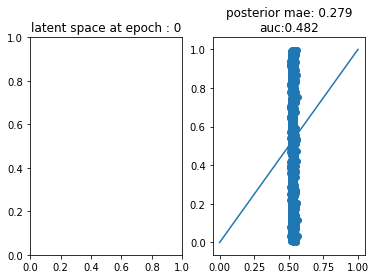

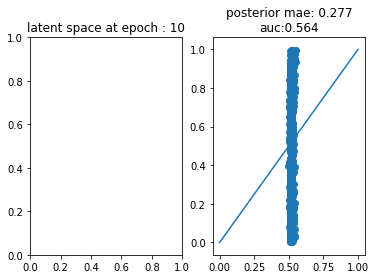

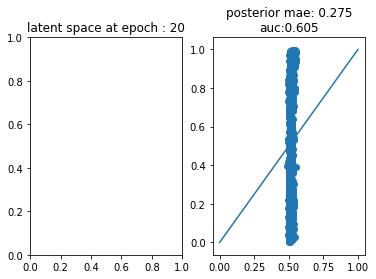

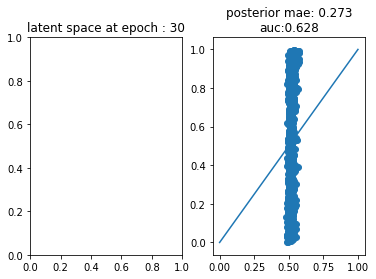

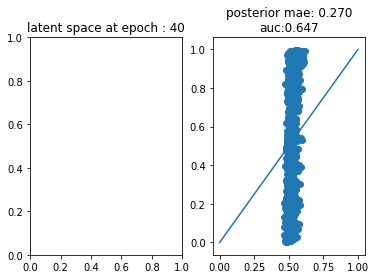

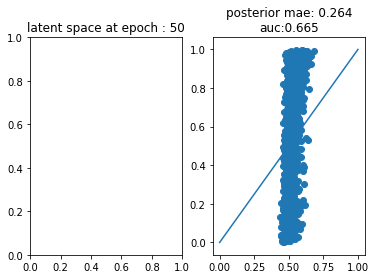

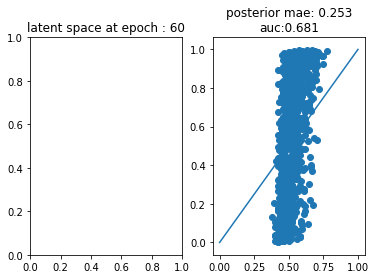

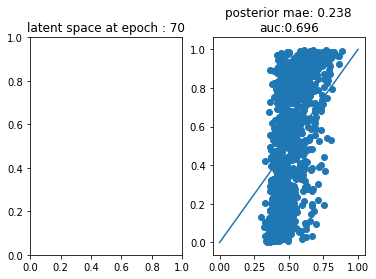

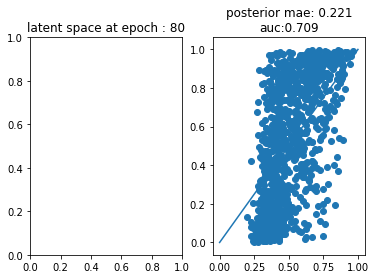

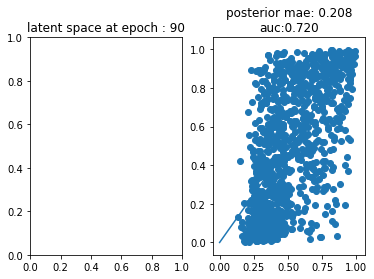

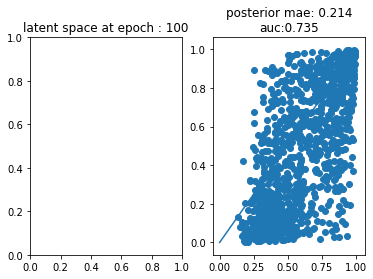

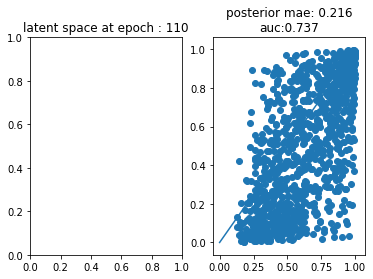

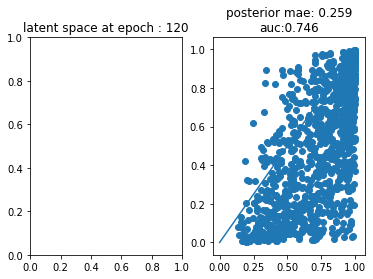

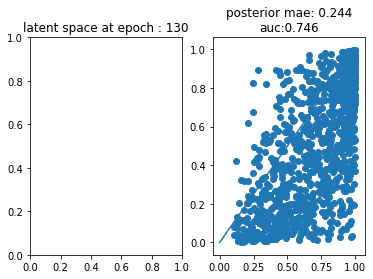

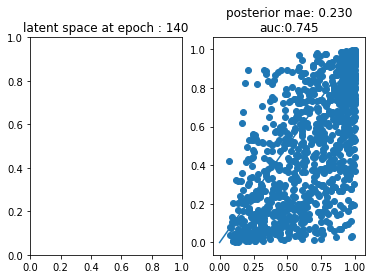

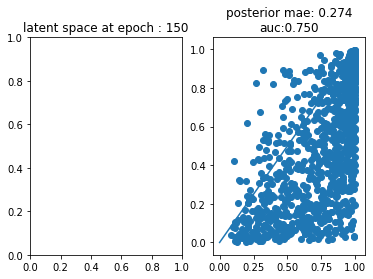

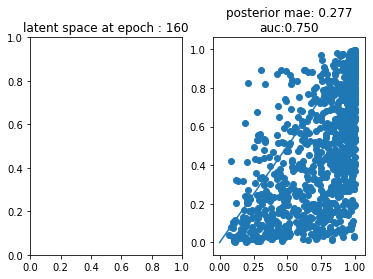

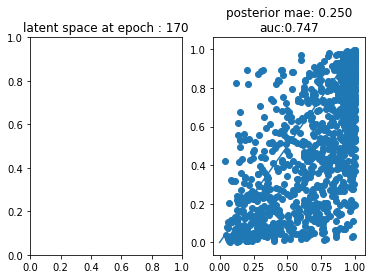

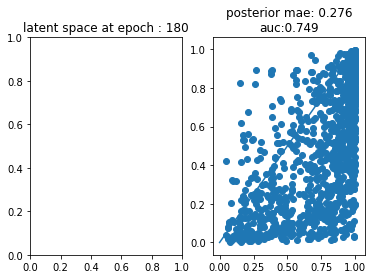

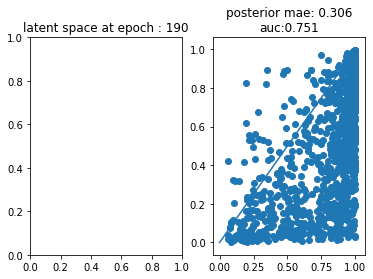

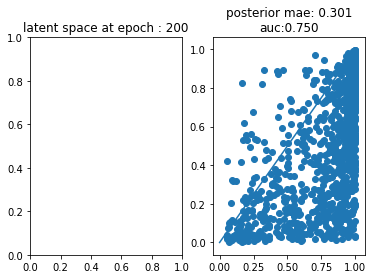

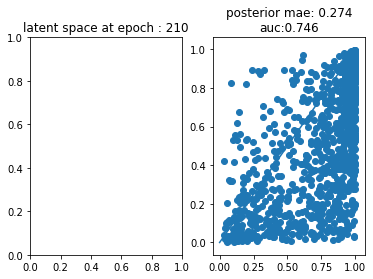

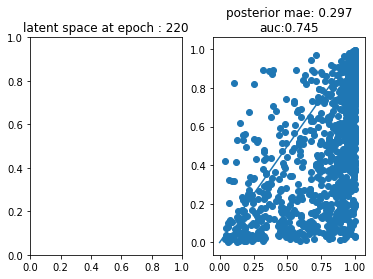

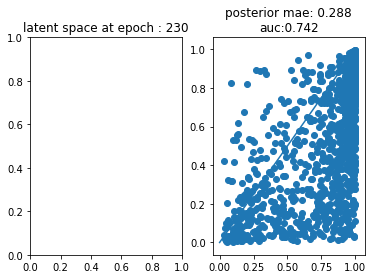

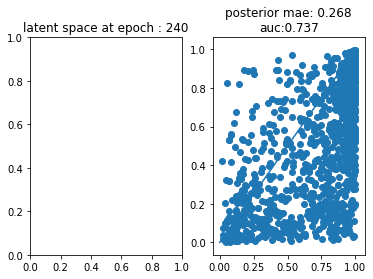

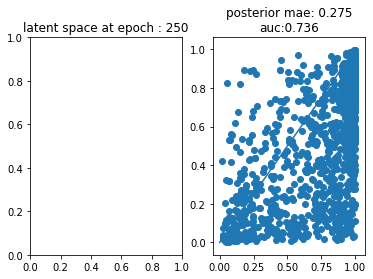

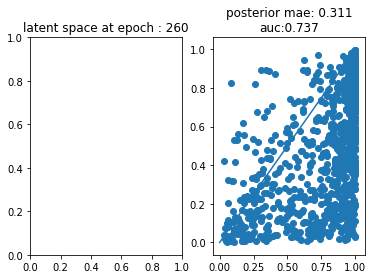

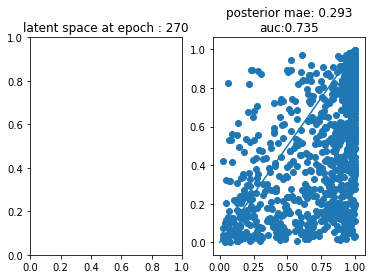

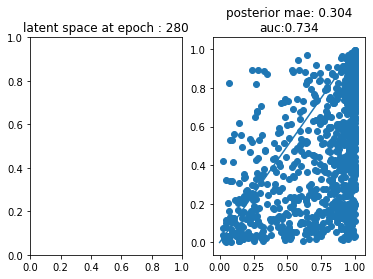

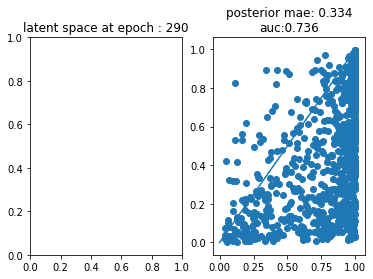

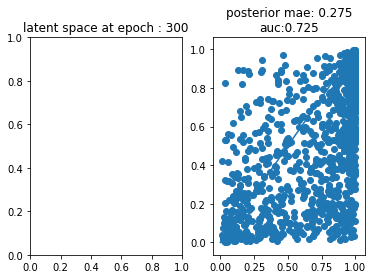

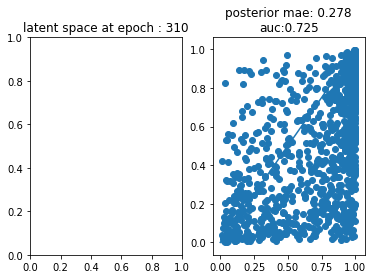

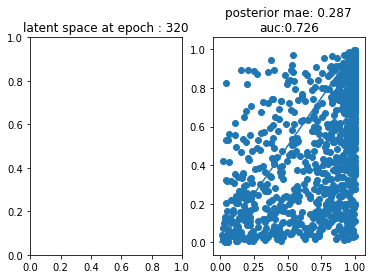

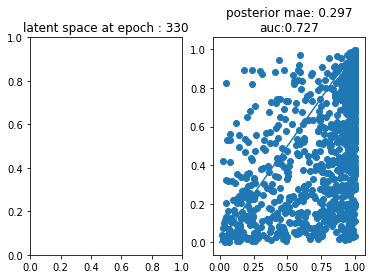

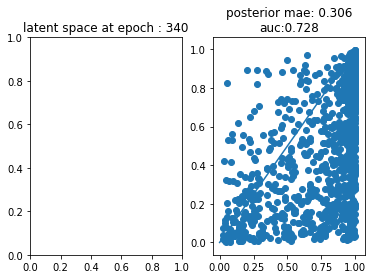

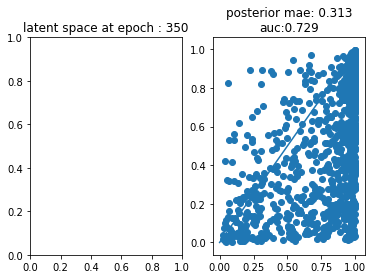

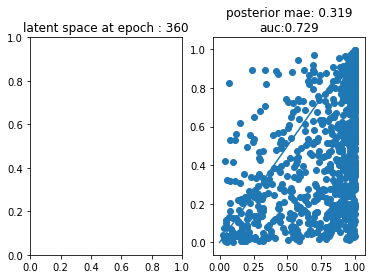

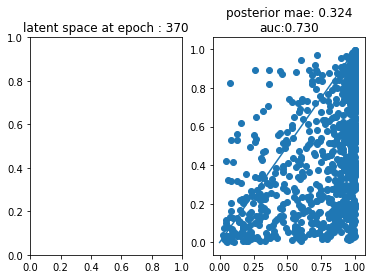

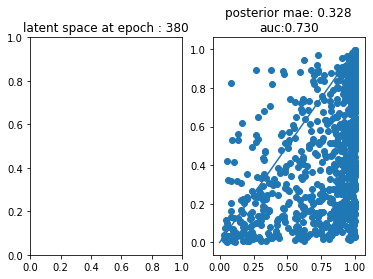

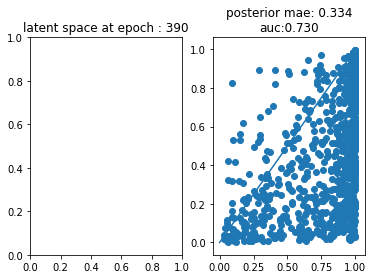

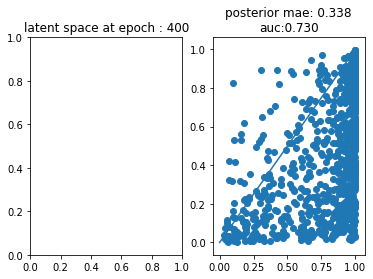

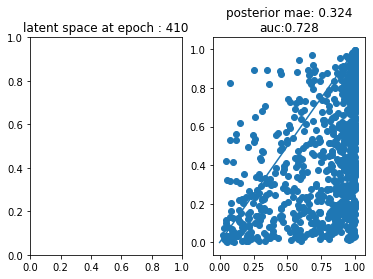

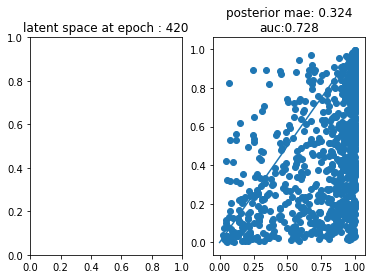

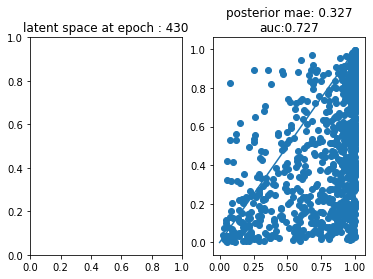

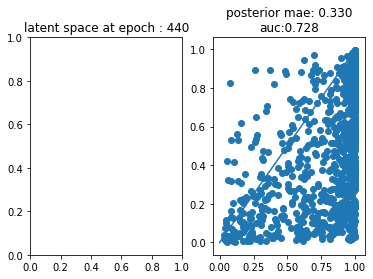

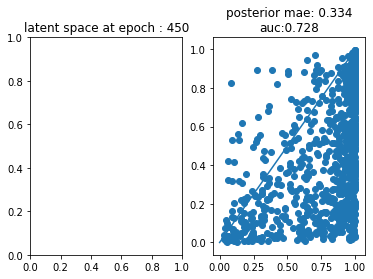

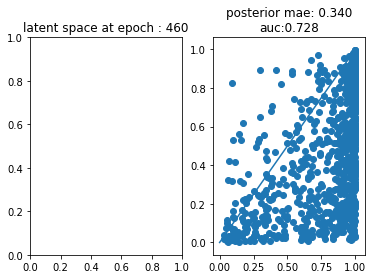

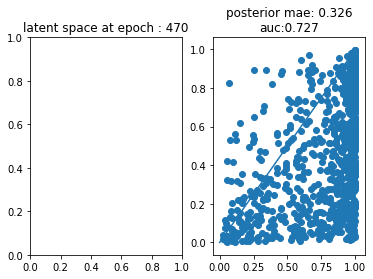

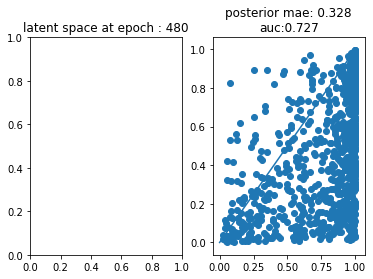

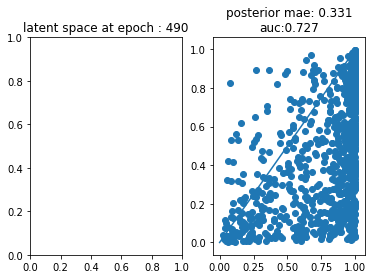

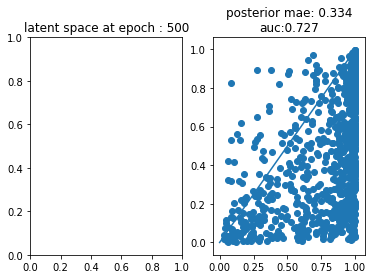

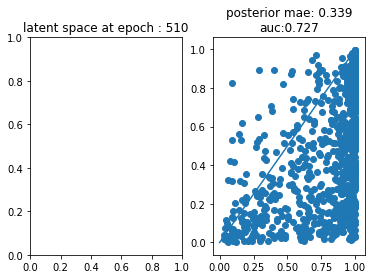

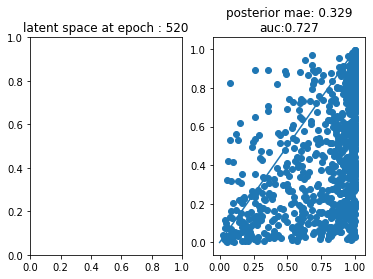

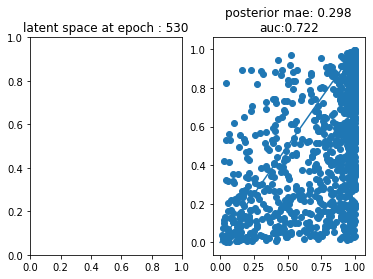

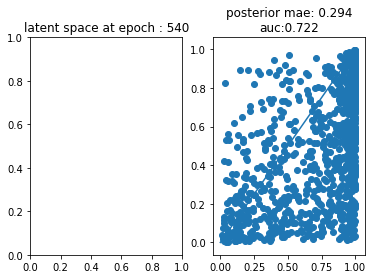

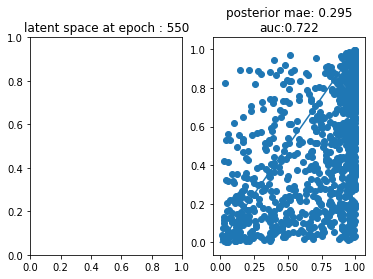

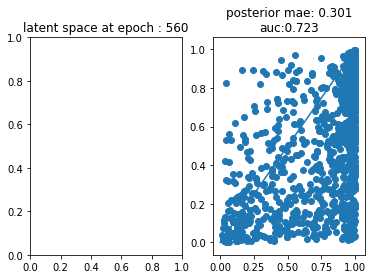

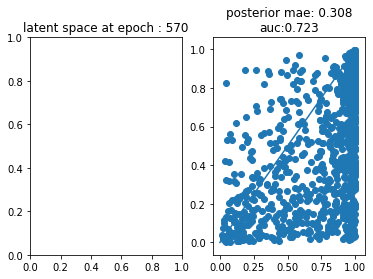

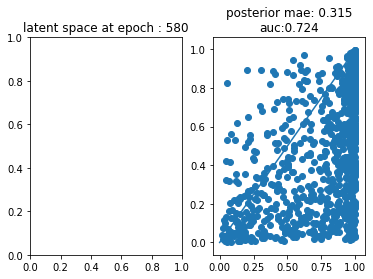

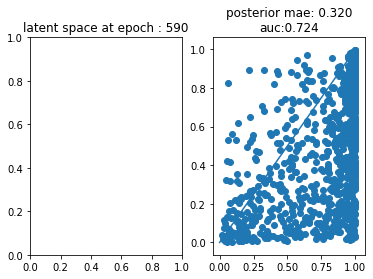

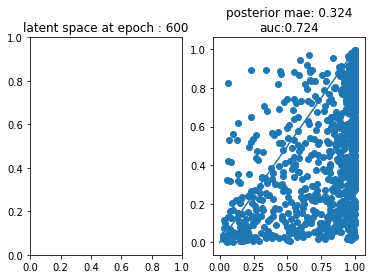

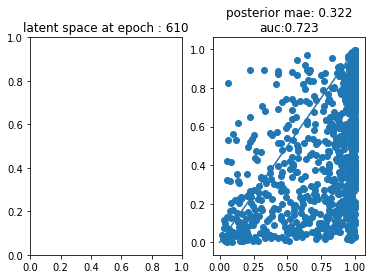

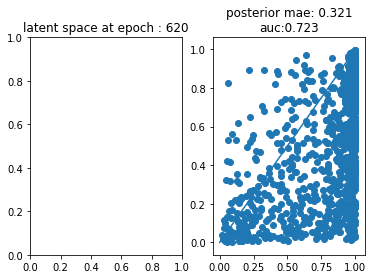

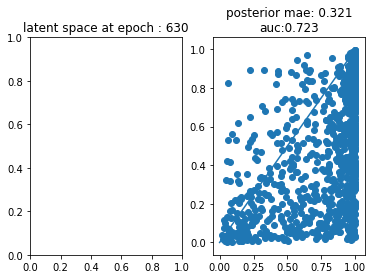

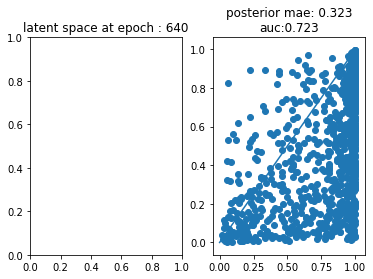

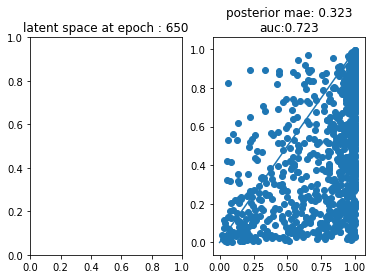

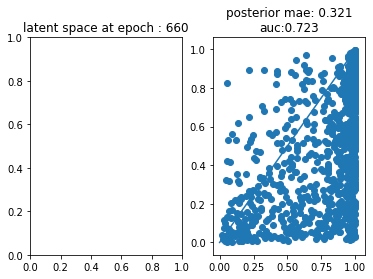

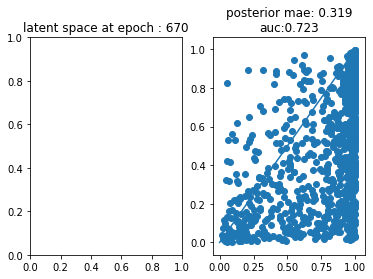

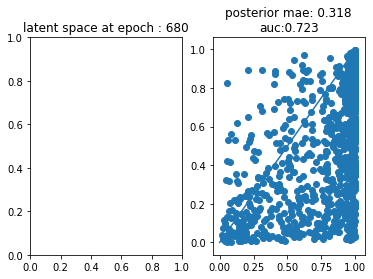

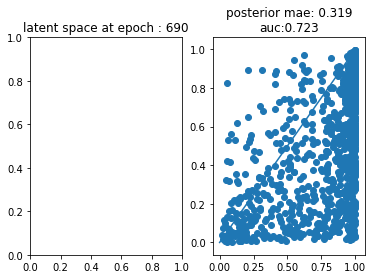

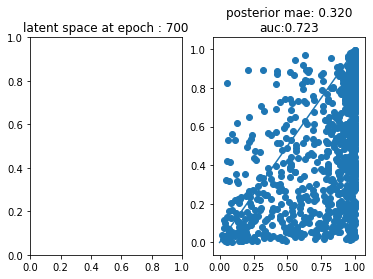

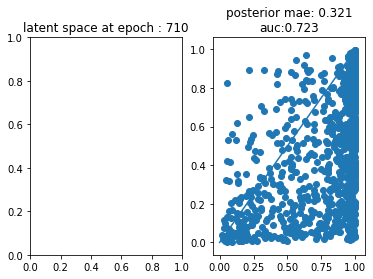

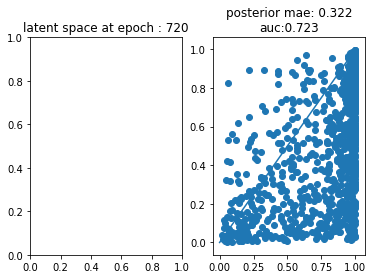

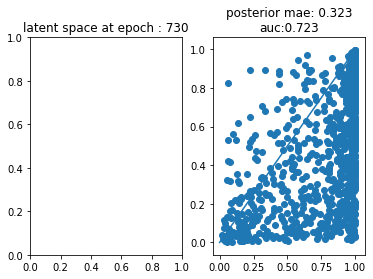

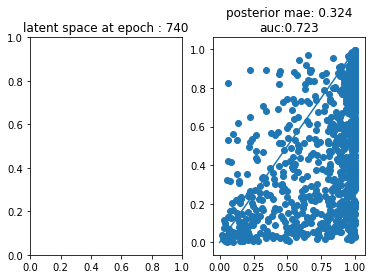

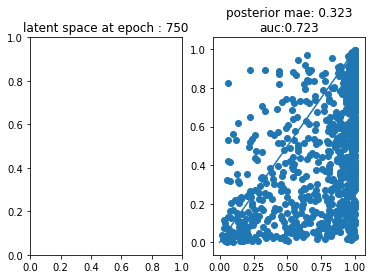

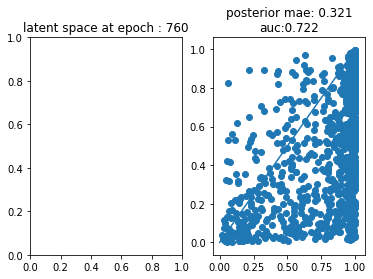

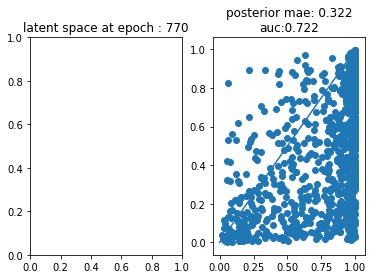

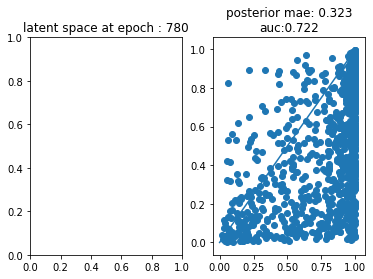

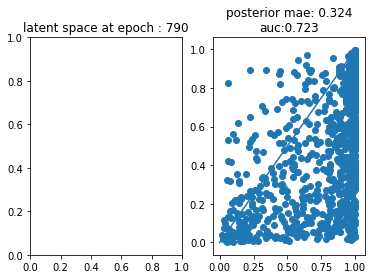

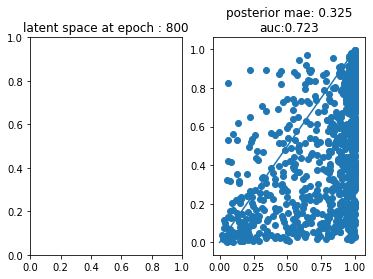

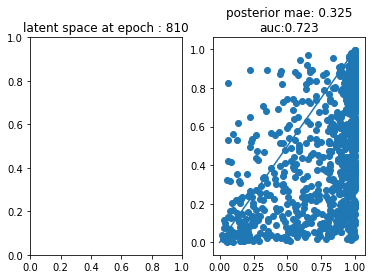

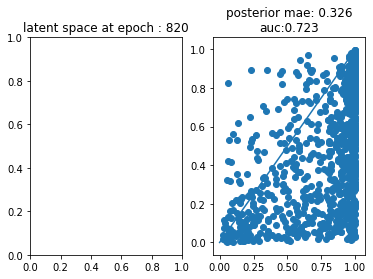

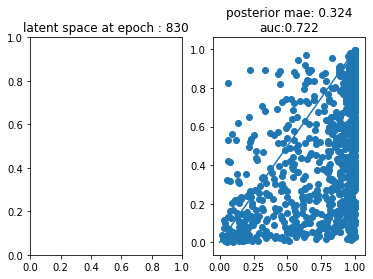

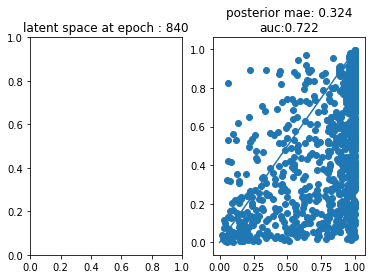

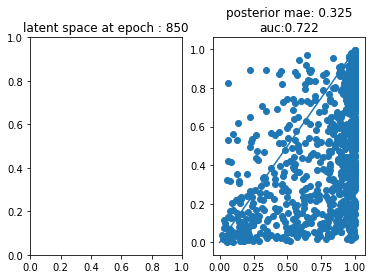

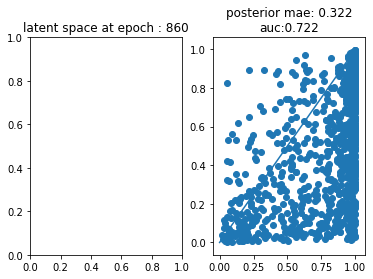

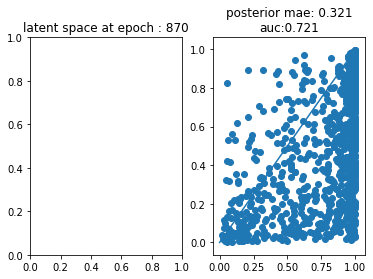

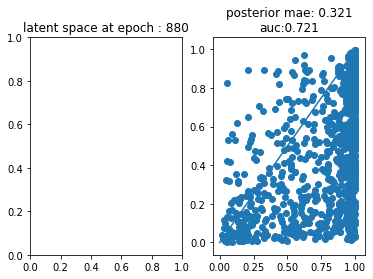

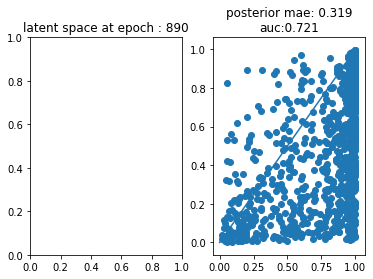

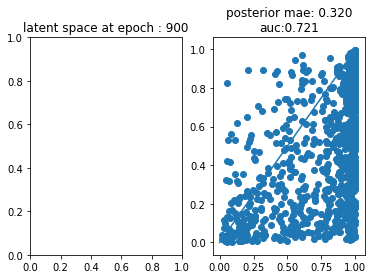

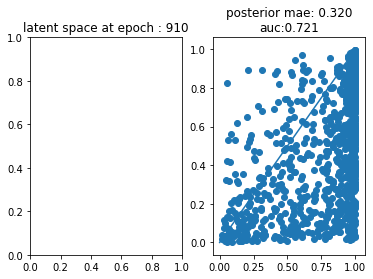

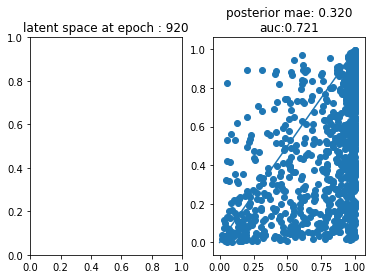

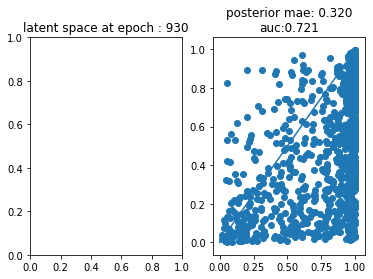

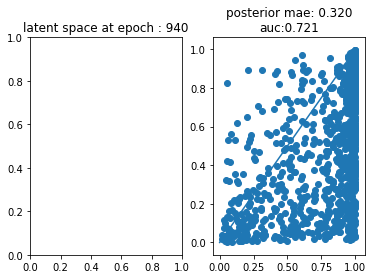

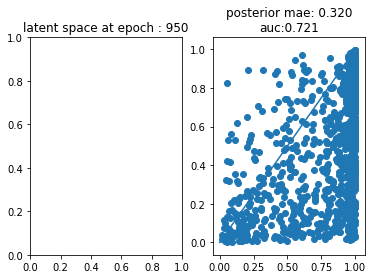

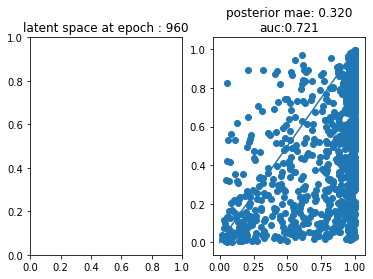

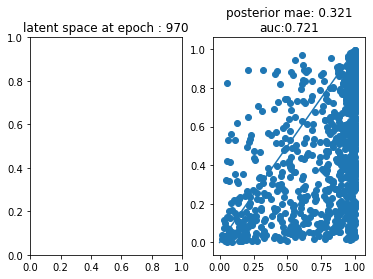

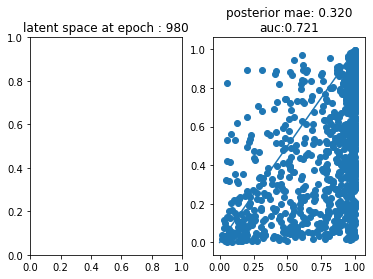

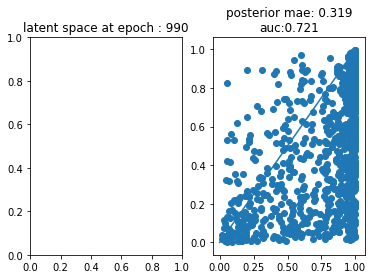

In [612]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
opt1 = tf.keras.optimizers.Adam(learning_rate=1e-4)
opt2 = tf.keras.optimizers.Adam(learning_rate=1e-4)
opt3 = tf.keras.optimizers.Adam(learning_rate=1e-4)
FREEZE_ENCODER_EPOCH = 1000
LRDECAYFACTOR = 5
lossFn= LossFn(classPrior)
posteriorMAEs= []
mse = tf.keras.losses.MeanSquaredError()
for epoch in trange(1000):
    if epoch in [300,600,900]:
        opt.lr.assign(opt.lr/LRDECAYFACTOR)
        opt1.lr.assign(opt1.lr/LRDECAYFACTOR)
        opt2.lr.assign(opt2.lr/LRDECAYFACTOR)
        opt3.lr.assign(opt3.lr/LRDECAYFACTOR)
    ############# SAMPLE DATA ###########################
    _,y_pu,x_p,x_u, _ = batch(np.concatenate((xPosTrain,xUnlabeledTrain)),
                           np.concatenate((np.ones(xPosTrain.shape[0]),
                                           np.zeros(xUnlabeledTrain.shape[0])))[:,None],128,128)
    ################### AE STEP #########################
    with tf.GradientTape() as tape:
        out_pos = decoder(encoder(x_p))
        out_unlabeled = decoder(encoder(x_u))
        total_loss = mse(x_p, out_pos)
        total_loss += mse(x_u,out_unlabeled)
    grads = tape.gradient(total_loss, encoder.trainable_variables + decoder.trainable_variables)
    opt.apply_gradients(zip(grads, encoder.trainable_variables + decoder.trainable_variables))
    ################ NNPU STEP ##########################
    with tf.GradientTape() as tape:
        out_pos = discriminator(encoder(x_p))
        out_unlabeled = discriminator(encoder(x_u))
        total_loss = lossFn(out_pos,out_unlabeled)
    if epoch < FREEZE_ENCODER_EPOCH:
        grads = tape.gradient(total_loss,encoder.trainable_variables + discriminator.trainable_variables)
        opt1.apply_gradients(zip(grads,encoder.trainable_variables + discriminator.trainable_variables))
    else:
        grads = tape.gradient(total_loss,discriminator.trainable_variables)
        opt1.apply_gradients(zip(grads, discriminator.trainable_variables))
    if epoch < FREEZE_ENCODER_EPOCH:
        ################# Generator Step ####################
        with tf.GradientTape() as tape:
            #pos_adversary_decisions = adversary(encoder(x_p))
            unlabeled_adversary_decisions = adversary(encoder(x_u))
            generator_loss = cross_entropy_with_logits(unlabeled_adversary_decisions, tf.ones(x_u.shape[0]))
#             generator_loss += cross_entropy_with_logits(pos_adversary_decisions, tf.ones(x_p.shape[0]))
        grads =tape.gradient(generator_loss,encoder.trainable_variables)
        opt2.apply_gradients(zip(grads, encoder.trainable_variables))
        ################# Adversary Step ####################
        with tf.GradientTape() as tape:
            real_inputs = np.concatenate([
                np.random.multivariate_normal(np.zeros(ZDIM) + 0, np.eye(ZDIM),size=1000),
                np.random.multivariate_normal(np.zeros(ZDIM) - 0, np.eye(ZDIM),size=1000),
            ],axis=0)
            real_adversary_decisions = adversary(real_inputs)
            unlabeled_adversary_decisions = adversary(encoder(x_u))
            #pos_adversary_decisions = adversary(encoder(x_p))
            fake_loss = cross_entropy_with_logits(unlabeled_adversary_decisions, tf.zeros(x_u.shape[0]))
            #fake_loss += cross_entropy_with_logits(pos_adversary_decisions,tf.zeros(x_p.shape[0]))
            real_loss = cross_entropy_with_logits(real_adversary_decisions, tf.ones(real_inputs.shape[0]))
            loss = real_loss + fake_loss
        grads =tape.gradient(loss,adversary.trainable_variables)
        opt3.apply_gradients(zip(grads, adversary.trainable_variables))
    if not epoch % 10:
        encOut = encoder.predict(xUnlabeledVal)
        xUnlabeledValPosts = discriminator.predict(encOut)
        fig,ax = plt.subplots(1,2)
        ax[1].scatter(xUnlabeledValPosts,posterior(xUnlabeledVal))
        ax[1].plot([0,1],[0,1])
        pmae=  np.mean(np.abs(xUnlabeledValPosts.ravel() - posterior(xUnlabeledVal).ravel()))
        posteriorMAEs.append(pmae)
        ax[1].set_title("posterior mae: {:.3f}\nauc:{:.3f}".format(pmae,
                                                         roc_auc_score(yPNVal,xUnlabeledValPosts)))
        if ZDIM == 2:
            ax[0].scatter(*encOut.T,c=yPNVal)
        ax[0].set_title("latent space at epoch : {}".format(epoch))
        plt.show()

Text(0.5, 1.0, 'posterior MAE (min : 0.208)')

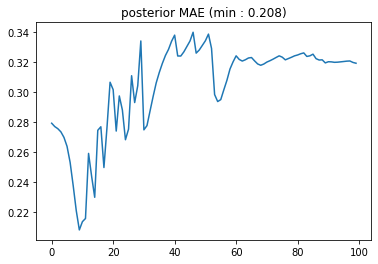

In [613]:
plt.plot(posteriorMAEs)
plt.title("posterior MAE (min : {:.3f})".format(np.min(posteriorMAEs)))

# Baseline

In [614]:
baseline_inputs = keras.Input(shape=DIM,name="baseline_inputs")
baselinelayers = keras.models.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu")
])
baseline_output = layers.Dense(1,activation="sigmoid",name="baseline_output")(baselinelayers(baseline_inputs))
baselineModel = keras.Model([baseline_inputs],
                            [baseline_output],name="baselineModel")
baselineModel.summary()


Model: "baselineModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 baseline_inputs (InputLayer  [(None, 32)]             0         
 )                                                               
                                                                 
 sequential_248 (Sequential)  (None, 128)              37248     
                                                                 
 baseline_output (Dense)     (None, 1)                 129       
                                                                 
Total params: 37,377
Trainable params: 37,377
Non-trainable params: 0
_________________________________________________________________


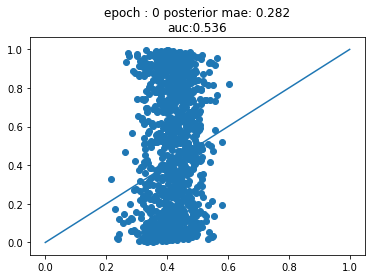

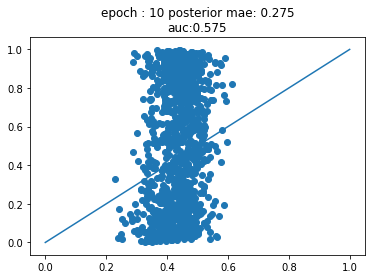

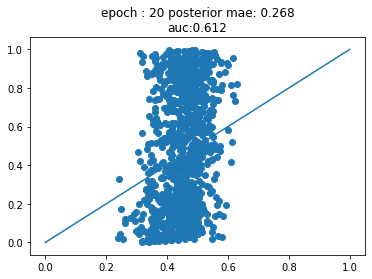

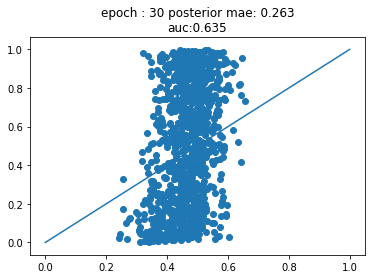

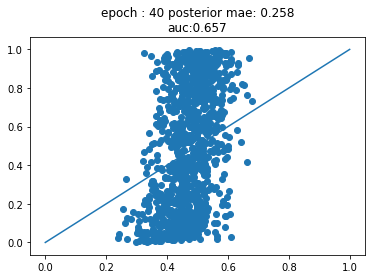

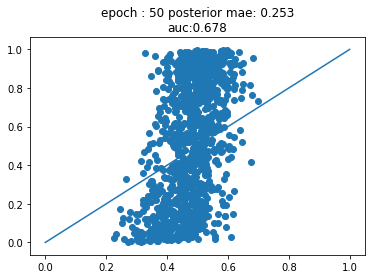

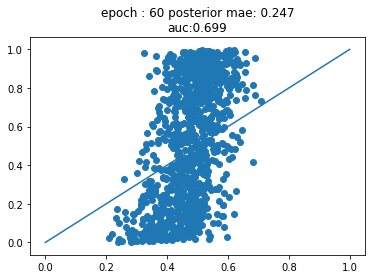

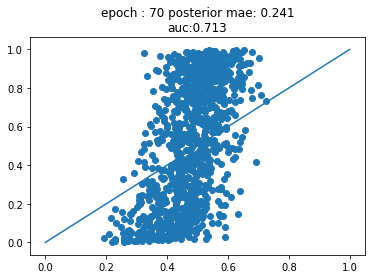

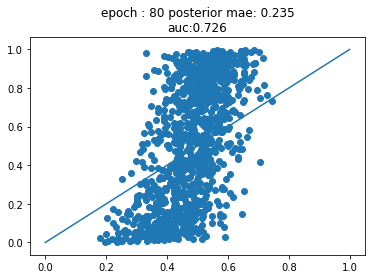

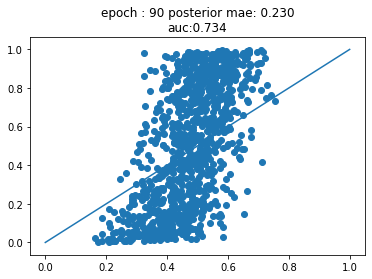

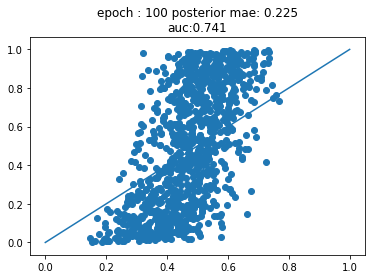

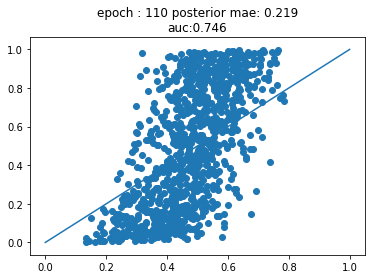

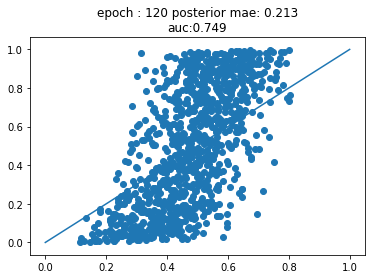

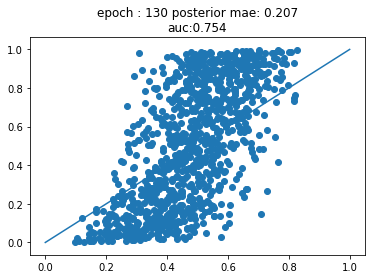

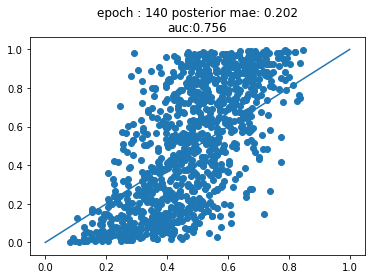

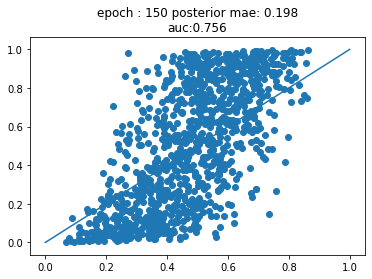

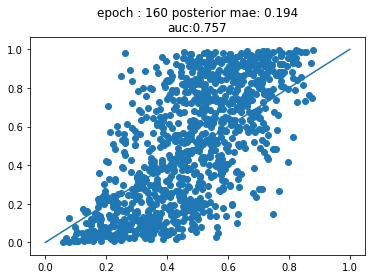

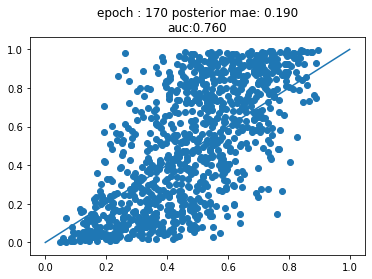

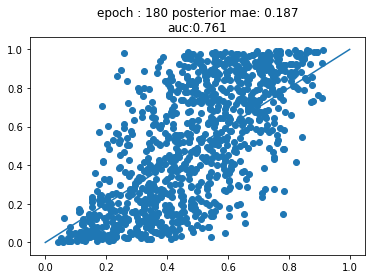

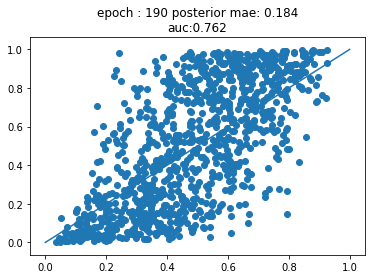

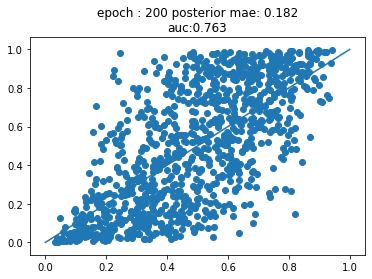

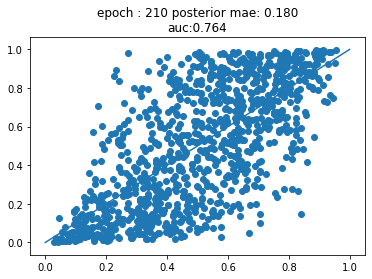

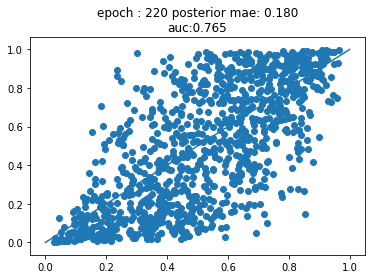

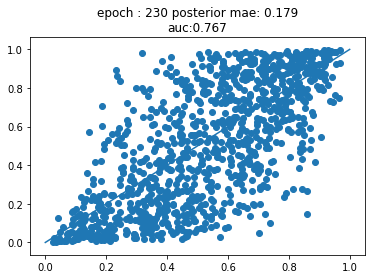

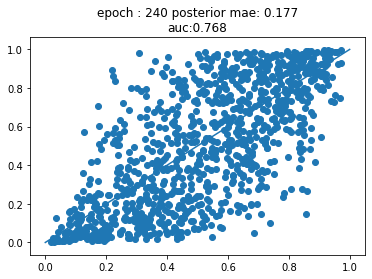

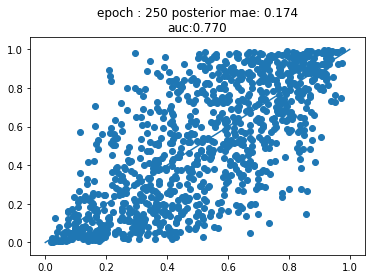

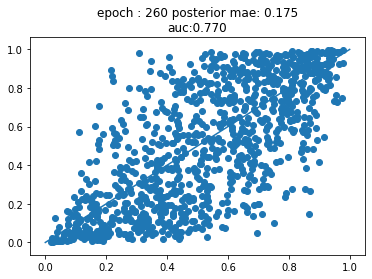

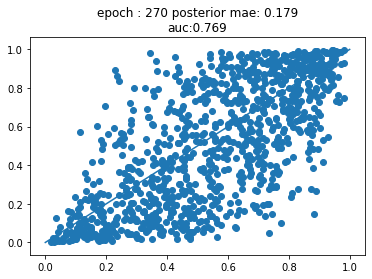

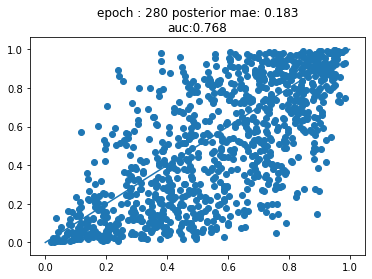

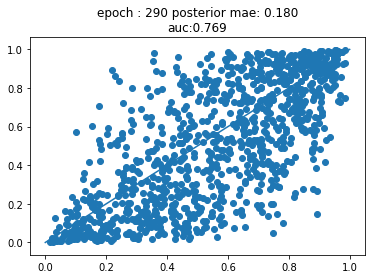

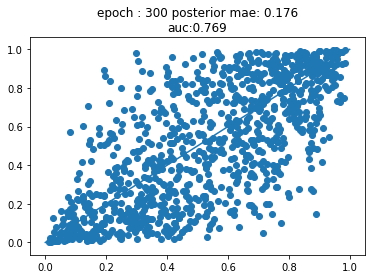

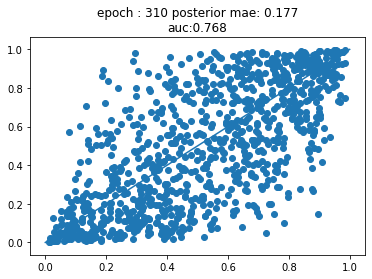

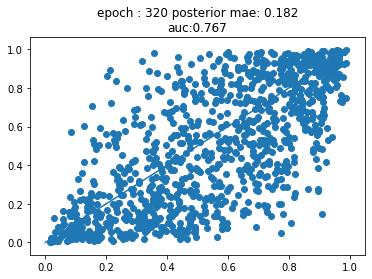

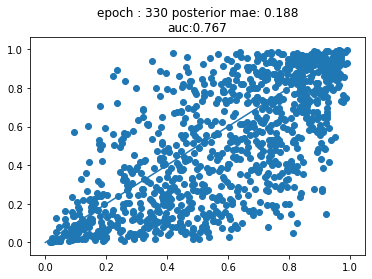

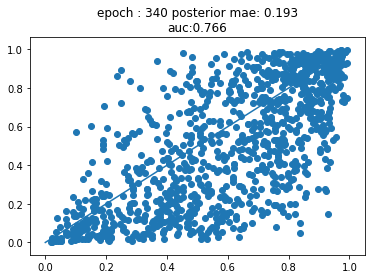

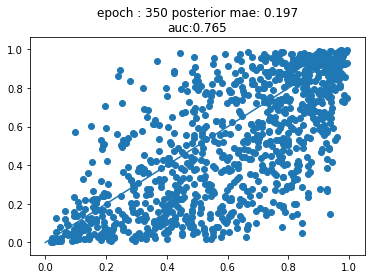

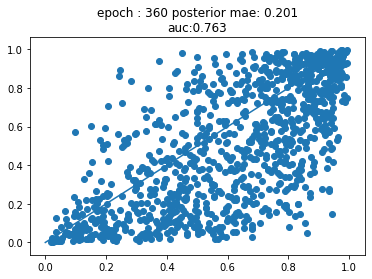

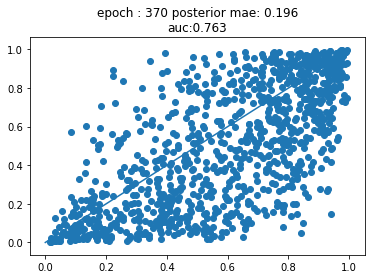

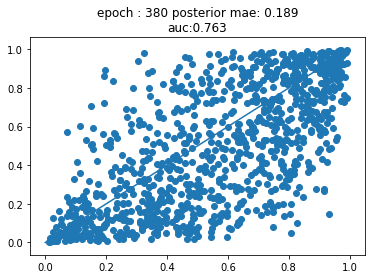

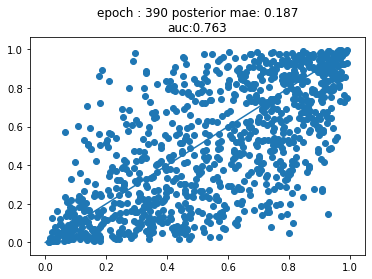

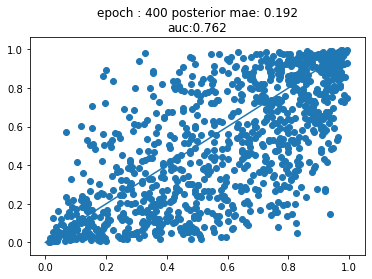

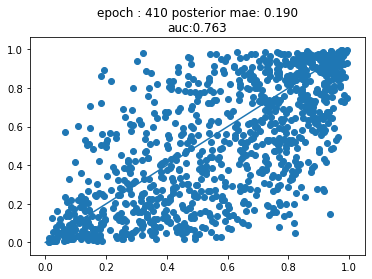

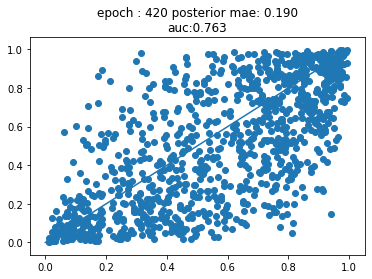

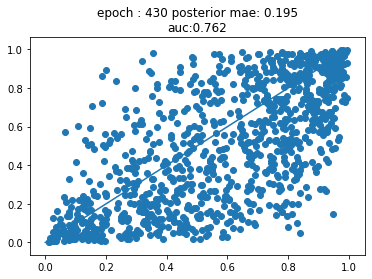

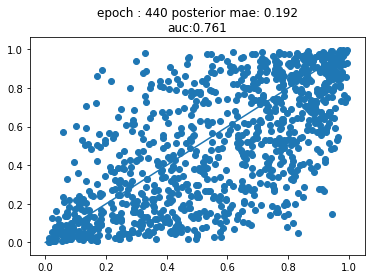

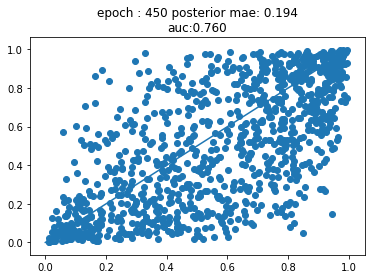

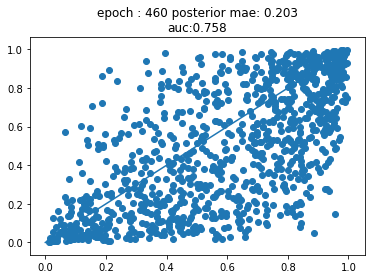

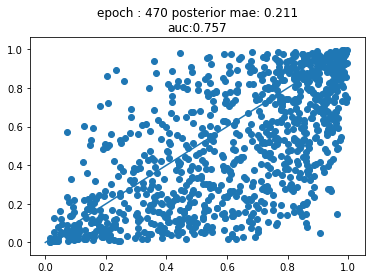

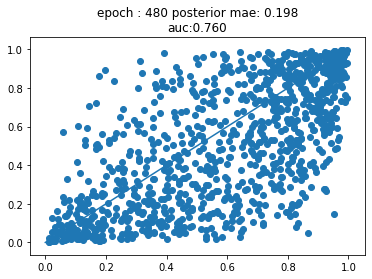

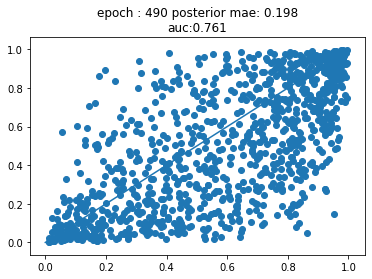

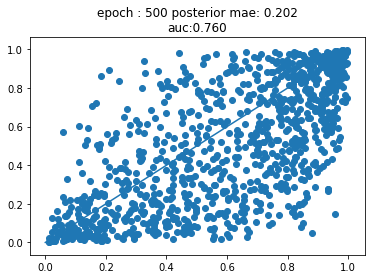

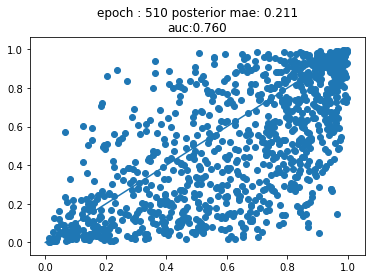

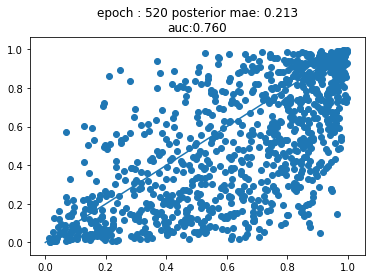

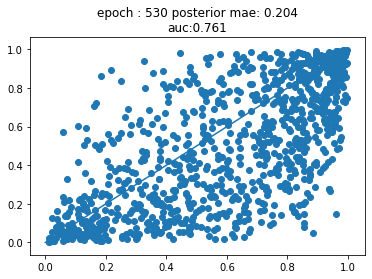

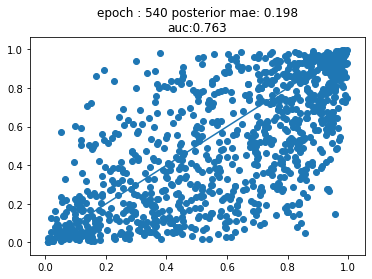

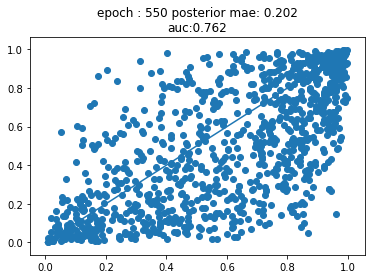

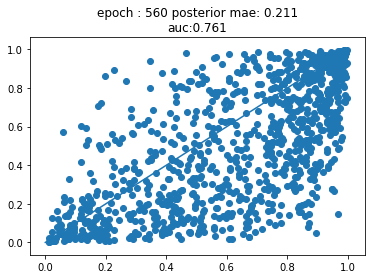

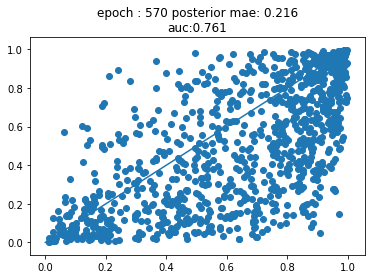

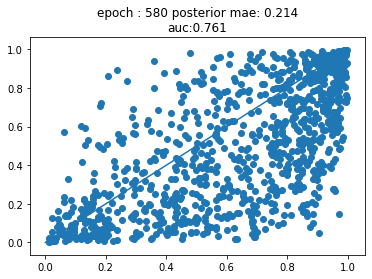

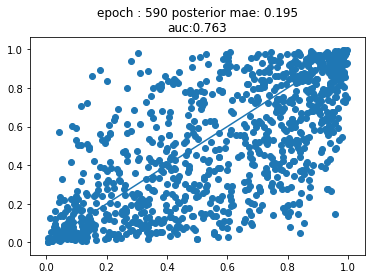

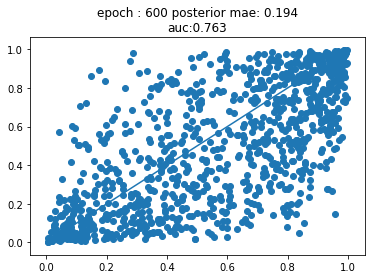

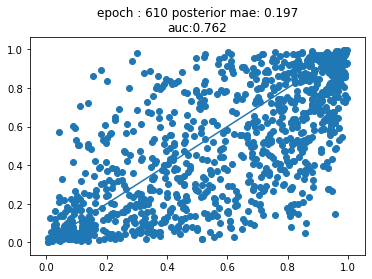

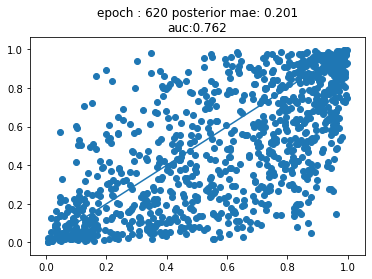

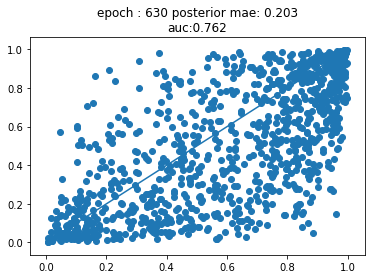

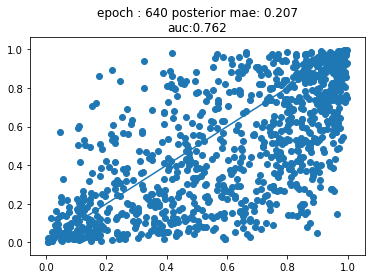

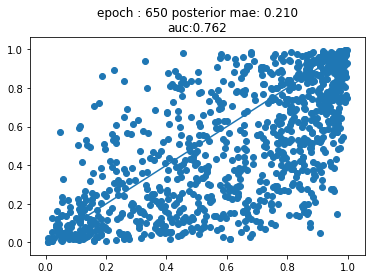

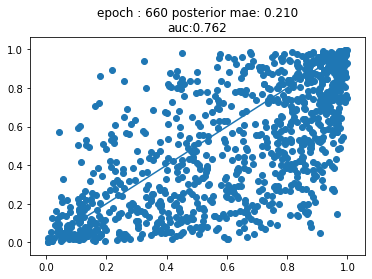

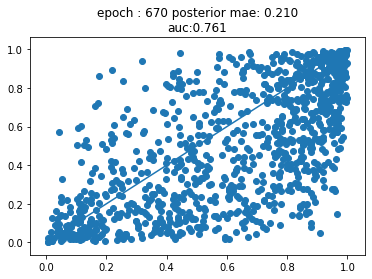

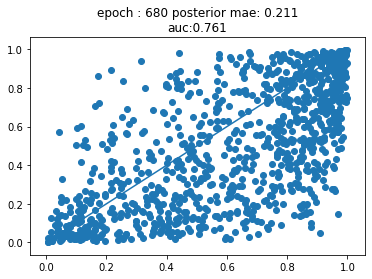

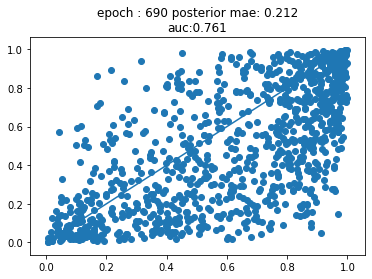

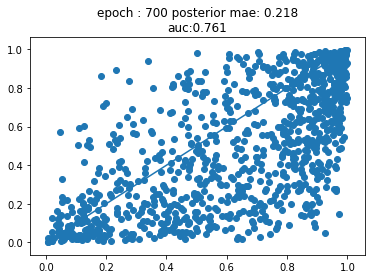

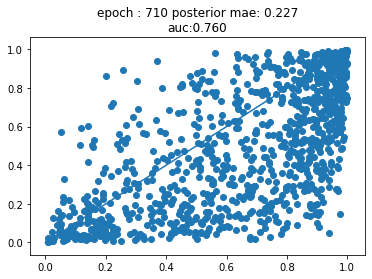

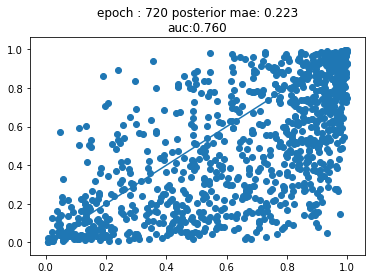

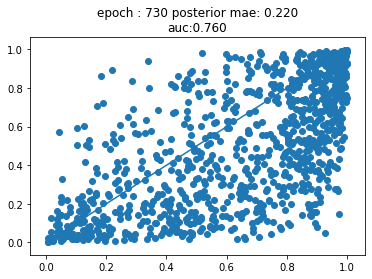

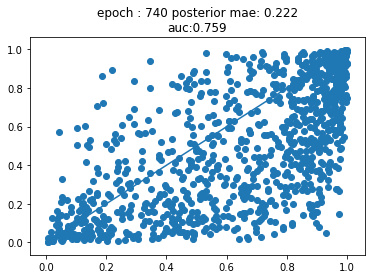

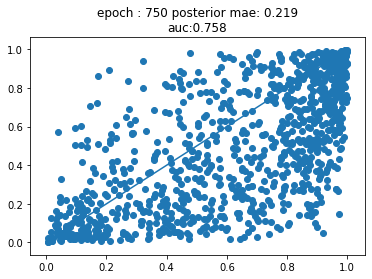

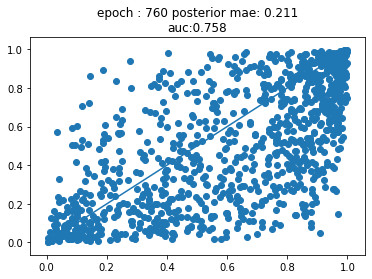

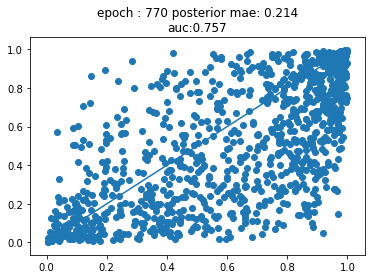

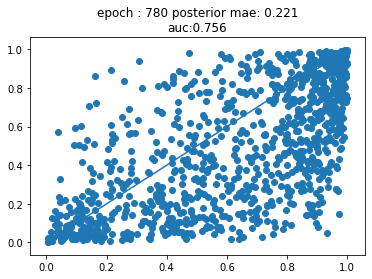

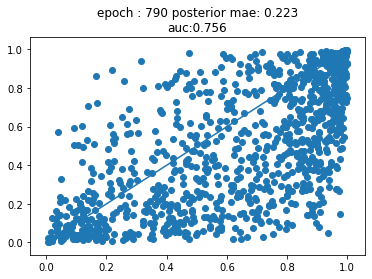

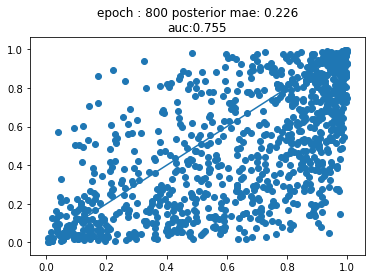

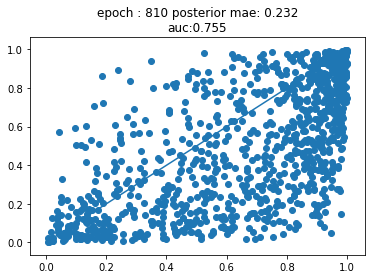

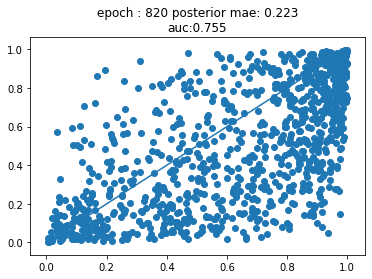

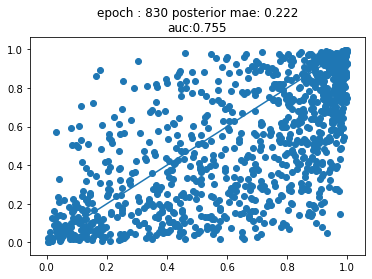

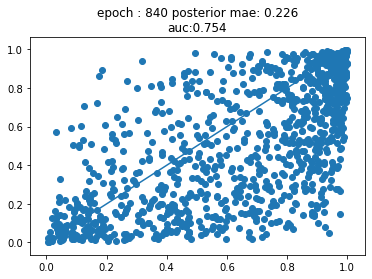

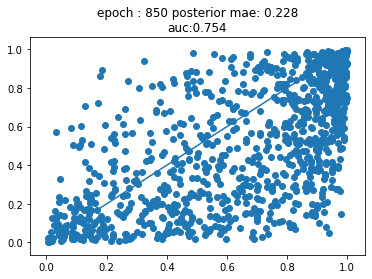

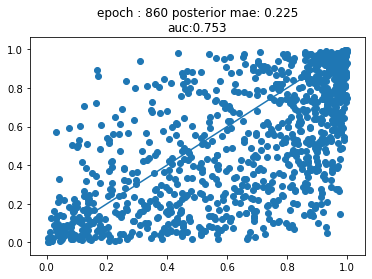

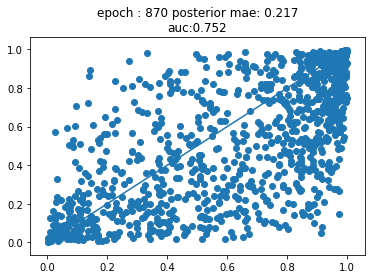

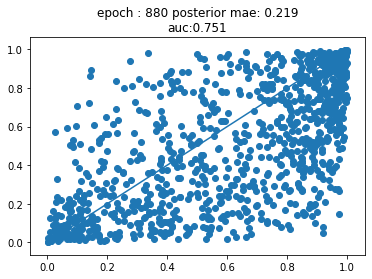

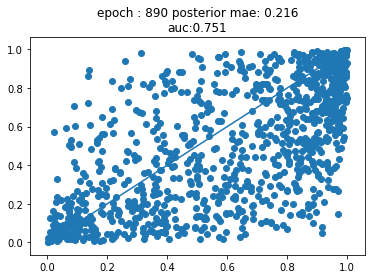

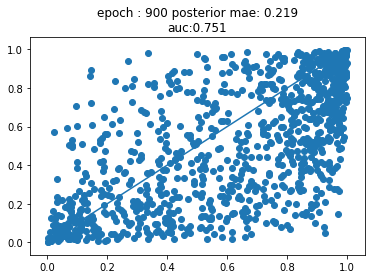

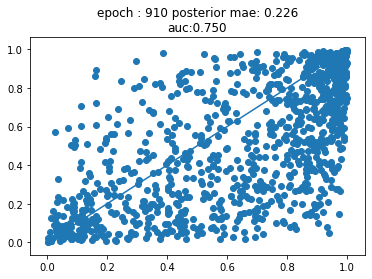

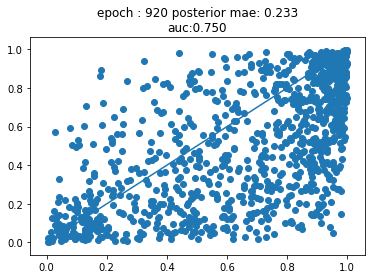

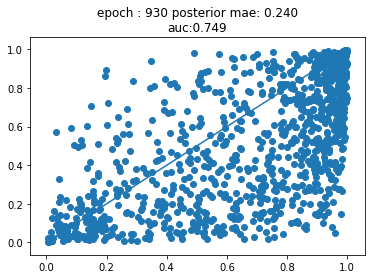

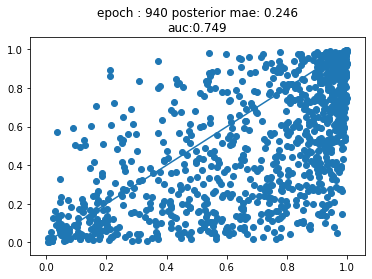

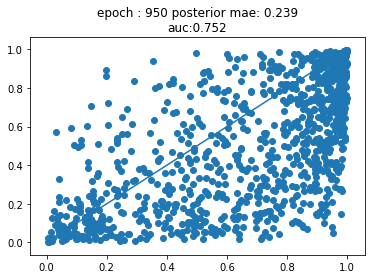

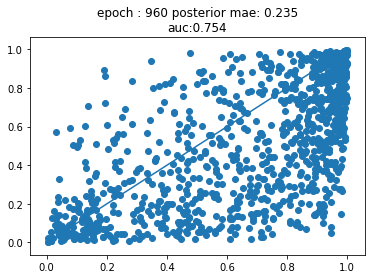

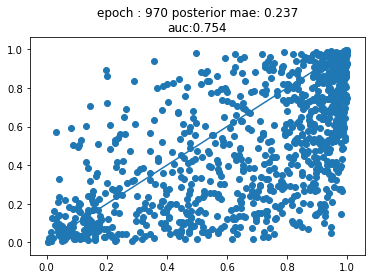

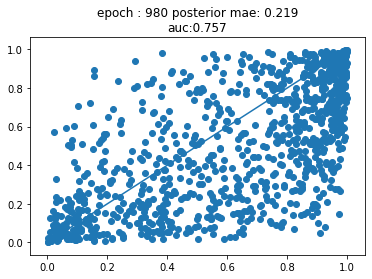

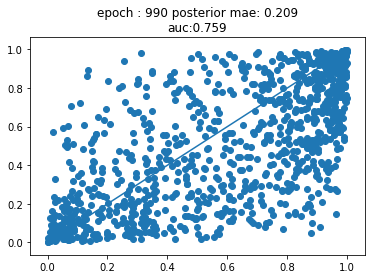

In [615]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
baselinePosteriorMAEs = []
lossFn= LossFn(classPrior)
for epoch in trange(1000):
    _,_,x_p,x_u, _ = batch(np.concatenate((xPosTrain,xUnlabeledTrain)),
                           np.concatenate((np.ones(xPosTrain.shape[0]),
                                           np.zeros(xUnlabeledTrain.shape[0])))[:,None],32,32)
    with tf.GradientTape() as tape:
        out_pos = baselineModel(x_p)
        out_unlabeled = baselineModel(x_u)
        total_loss = lossFn(out_pos,out_unlabeled)
    grads = tape.gradient(total_loss,baselineModel.trainable_variables)
    opt.apply_gradients(zip(grads,baselineModel.trainable_variables))
    if not epoch % 10:
            xUnlabeledValPosts = baselineModel.predict(xUnlabeledVal)
            plt.scatter(xUnlabeledValPosts,posterior(xUnlabeledVal))
            plt.plot([0,1],[0,1])
            pmae= np.mean(np.abs(xUnlabeledValPosts.ravel() - posterior(xUnlabeledVal).ravel()))
            baselinePosteriorMAEs.append(pmae)
            plt.title("epoch : {} posterior mae: {:.3f}\nauc:{:.3f}".format(epoch,pmae,
                                                             roc_auc_score(yPNVal,xUnlabeledValPosts)))
            plt.show()

Text(0.5, 1.0, 'posterior MAE (min : 0.174)')

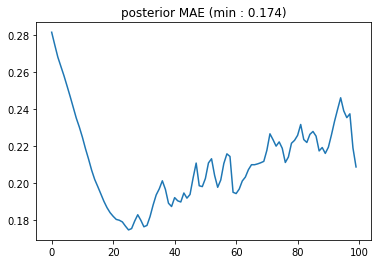

In [616]:
plt.plot(baselinePosteriorMAEs)
plt.title("posterior MAE (min : {:.3f})".format(np.min(baselinePosteriorMAEs)))